In [1]:
import pandas as pd
import numpy as np
import SimpleITK as sitk

In [2]:
df = pd.read_csv('results.csv', index_col=0)

In [3]:
df_temp = df.groupby('patient')[['view']].count()
idx = df_temp[df_temp.view!=6].index
df = df[~df['patient'].isin(idx)]
df

,fold,patient,dice,TP,TN,FP,FN,n_pred,n_ref,precision,recall,type,view,dilated_dice
0,fold_0,1525150.nii,0.000000,0,8623817,0,183,0,183,0.000000,0.000000,normal,axial,0.000000
2,fold_0,1856568.nii,0.580206,2984,5374842,717,3601,3701,6585,0.806269,0.453151,normal,axial,0.715341
3,fold_0,324035.nii,0.000000,0,4504974,231,395,231,395,0.000000,0.000000,normal,axial,0.000000
4,fold_0,390232.nii,0.299465,616,5378646,772,2110,1388,2726,0.443804,0.225972,normal,axial,0.402042
5,fold_0,5018199.nii,0.000000,0,3357868,0,852,0,852,0.000000,0.000000,normal,axial,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
351,fold_4,5283984.nii,0.379966,1927,56991720,2409,3880,4336,5807,0.444419,0.331841,da,sagittal,0.500049
352,fold_4,928807.nii,0.221811,360,7200954,1206,1320,1566,1680,0.229885,0.214286,da,sagittal,0.416513
353,fold_4,928807_1.nii,0.000000,0,56991489,0,8447,0,8447,0.000000,0.000000,da,sagittal,0.000000
354,fold_4,94628.nii,0.249403,2296,56983820,394,13426,2690,15722,0.853532,0.146037,da,sagittal,0.382142


In [4]:
df = df[df.type == 'da']
df

,fold,patient,dice,TP,TN,FP,FN,n_pred,n_ref,precision,recall,type,view,dilated_dice
178,fold_0,1525150.nii,0.000000,0,8623726,91,183,91,183,0.000000,0.000000,da,axial,0.000000
180,fold_0,1856568.nii,0.617212,3507,5374287,1272,3078,4779,6585,0.733836,0.532574,da,axial,0.761352
181,fold_0,324035.nii,0.000000,0,4504813,392,395,392,395,0.000000,0.000000,da,axial,0.000000
182,fold_0,390232.nii,0.129093,276,5378144,1274,2450,1550,2726,0.178065,0.101247,da,axial,0.180543
183,fold_0,5018199.nii,0.265861,132,3357859,9,720,141,852,0.936170,0.154930,da,axial,0.461229
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
351,fold_4,5283984.nii,0.379966,1927,56991720,2409,3880,4336,5807,0.444419,0.331841,da,sagittal,0.500049
352,fold_4,928807.nii,0.221811,360,7200954,1206,1320,1566,1680,0.229885,0.214286,da,sagittal,0.416513
353,fold_4,928807_1.nii,0.000000,0,56991489,0,8447,0,8447,0.000000,0.000000,da,sagittal,0.000000
354,fold_4,94628.nii,0.249403,2296,56983820,394,13426,2690,15722,0.853532,0.146037,da,sagittal,0.382142


In [5]:
df_temp = df.groupby('patient')[['dice']].mean().reset_index()
df_temp = df_temp[df_temp.dice == 0]
ids = df_temp['patient']

In [6]:
d = {
    '1504261.nii' : [1,1,0],
     '1513290.nii' : [0,0,0],
     '1525150.nii' : [1,0,0],
     '1761942.nii' : [0,0,0],
     '284282.nii' : [1,1,1],
     '321585.nii' : [0,1,0],
     '324035.nii' : [1,1,0],
     '5107844.nii' : [1,1,0],
     '5198373.nii' : [1,0,0],
     '5217962.nii' : [0,0,0],
     '5223120.nii' : [1,1,1]
}

In [7]:
df2 = df.copy()

In [8]:
def compute_stats(pred, label):
    
    tp = np.sum(np.logical_and(pred == 1, label == 1))
    tn = np.sum(np.logical_and(pred == 0, label == 0))
    
    fp = np.sum(np.logical_and(pred == 1, label == 0))
    fn = np.sum(np.logical_and(pred == 0, label == 1))
    
    n_pred = np.sum(pred)
    n_ref = np.sum(label)
    
    dice = 2*tp/(2*tp + fp + fn)
    precision = tp/(tp + fp)
    recall = tp/(tp + fn)
    
    return tp, tn, fp, fn, dice, precision, recall

In [9]:
import os
for patient in ids:
    for i, view in enumerate(['axial', 'coronal', 'sagittal']):
        
        if d[patient][i] == 1:
            # read pred and label
            label = os.path.join('./sorted/', view, patient.split('.')[0], 'label.nii')
            pred = os.path.join('./sorted/', view, patient.split('.')[0], 'pred_da.nii')
            
            label = sitk.ReadImage(label)
            pred = sitk.ReadImage(pred)
            
            label = sitk.GetArrayFromImage(label)
            pred = sitk.GetArrayFromImage(pred)
            
            # add the predicted to label
            label2 = np.logical_or(pred, label)
            
            # compute dice again
            tp, tn, fp, fn, dice, precision, recall = compute_stats(pred, label2)
            print(patient, view)
            print(tp, tn, fp, fn, dice, precision, recall)
            print()
            
            d[patient][i] = dice
            
            
        else:
            continue
        

1504261.nii axial
658 7837960 0 1382 0.4877687175685693 1.0 0.32254901960784316

1504261.nii coronal
3048 30498644 0 5316 0.5341745531019979 1.0 0.36441893830703015

1525150.nii axial
91 8623726 0 183 0.4986301369863014 1.0 0.33211678832116787

284282.nii axial
1177 5380445 0 522 0.8184979137691237 1.0 0.6927604473219541

284282.nii coronal
462 6719209 0 329 0.7374301675977654 1.0 0.584070796460177

284282.nii sagittal
650 5878624 0 534 0.7088331515812432 1.0 0.5489864864864865

321585.nii coronal
9 5913295 0 296 0.05732484076433121 1.0 0.029508196721311476

324035.nii axial
392 4504813 0 395 0.6649703138252756 1.0 0.49809402795425667

324035.nii coronal
1320 9182853 0 723 0.7850133809099019 1.0 0.6461086637298091

5107844.nii axial
200 5527674 0 1726 0.18814675446848542 1.0 0.10384215991692627

5107844.nii coronal
36 7923289 0 899 0.07415036045314109 1.0 0.038502673796791446

5198373.nii axial
1083 8464524 0 1593 0.5762170790103751 1.0 0.4047085201793722

5223120.nii axial
1318 616532

In [10]:
d

{'1504261.nii': [0.4877687175685693, 0.5341745531019979, 0],
 '1513290.nii': [0, 0, 0],
 '1525150.nii': [0.4986301369863014, 0, 0],
 '1761942.nii': [0, 0, 0],
 '284282.nii': [0.8184979137691237, 0.7374301675977654, 0.7088331515812432],
 '321585.nii': [0, 0.05732484076433121, 0],
 '324035.nii': [0.6649703138252756, 0.7850133809099019, 0],
 '5107844.nii': [0.18814675446848542, 0.07415036045314109, 0],
 '5198373.nii': [0.5762170790103751, 0, 0],
 '5217962.nii': [0, 0, 0],
 '5223120.nii': [0.8688200395517469, 0.7707509881422925, 0.48722986247544203]}

In [11]:
for patient in d.keys():
    for i, v in enumerate(['axial', 'coronal', 'sagittal']):
        
        if d[patient][i] != 0: 
        
            df_temp = df[(df.type=='da') & (df.view == v) & (df.patient == patient )]
            
            print(f"changing dice : from {df_temp.dice.tolist()[0]} to {d[patient][i]}")
            idx = df_temp.index.tolist()[0]
            
            df.at[idx, 'dice'] = d[patient][i]
            df.at[idx, 'dilated_dice'] = d[patient][i]
            df_temp = df[(df.type=='da') & (df.view == v) & (df.patient == patient )]
        else:
            continue


changing dice : from 0.0 to 0.4877687175685693
changing dice : from 0.0 to 0.5341745531019979
changing dice : from 0.0 to 0.4986301369863014
changing dice : from 0.0 to 0.8184979137691237
changing dice : from 0.0 to 0.7374301675977654
changing dice : from 0.0 to 0.7088331515812432
changing dice : from 0.0 to 0.05732484076433121
changing dice : from 0.0 to 0.6649703138252756
changing dice : from 0.0 to 0.7850133809099019
changing dice : from 0.0 to 0.18814675446848542
changing dice : from 0.0 to 0.07415036045314109
changing dice : from 0.0 to 0.5762170790103751
changing dice : from 0.0 to 0.8688200395517469
changing dice : from 0.0 to 0.7707509881422925
changing dice : from 0.0 to 0.48722986247544203


In [12]:
df[df.type=='da'].groupby('view')[['dice']].describe()

dice                                                         \
         count      mean       std  min       25%       50%       75%   
view                                                                    
axial     57.0  0.323468  0.286046  0.0  0.023157  0.265861  0.576217   
coronal   57.0  0.278974  0.271768  0.0  0.032452  0.171958  0.521958   
sagittal  57.0  0.294672  0.283932  0.0  0.000000  0.249403  0.549115   

                    
               max  
view                
axial     0.868820  
coronal   0.785013  
sagittal  0.840942

<Axes: xlabel='view', ylabel='dice'>

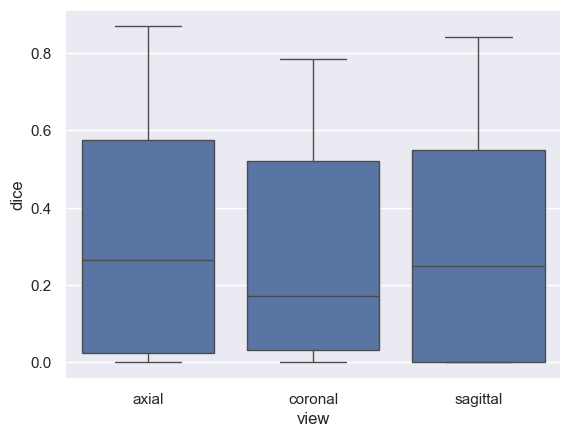

In [13]:
import seaborn as sns

sns.set()

sns.boxplot(data=df[df.type=='da'], x='view', y='dice')

In [14]:
df1 = df[df.type=='da'][['dice', 'view']]
df1['reviewed'] = True
df1

,dice,view,reviewed
178,0.498630,axial,True
180,0.617212,axial,True
181,0.664970,axial,True
182,0.129093,axial,True
183,0.265861,axial,True
...,...,...,...
351,0.379966,sagittal,True
352,0.221811,sagittal,True
353,0.000000,sagittal,True
354,0.249403,sagittal,True


In [15]:
df2 = df2[df2.type=='da'][['dice', 'view']]
df2['reviewed'] = False
df2

,dice,view,reviewed
178,0.000000,axial,False
180,0.617212,axial,False
181,0.000000,axial,False
182,0.129093,axial,False
183,0.265861,axial,False
...,...,...,...
351,0.379966,sagittal,False
352,0.221811,sagittal,False
353,0.000000,sagittal,False
354,0.249403,sagittal,False


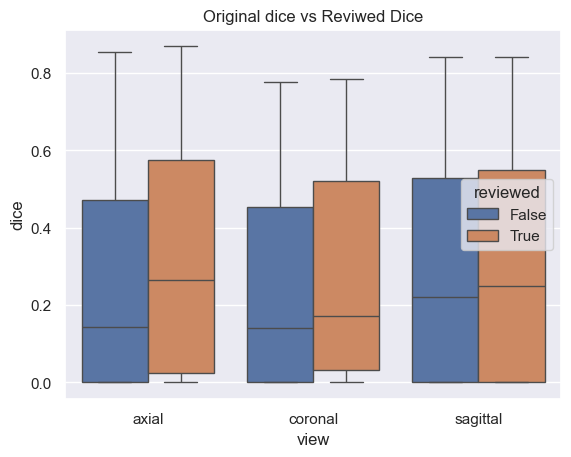

In [16]:
ddff = pd.concat([df1, df2])
import matplotlib.pyplot as plt

sns.boxplot(data=ddff, x='view', y='dice', hue='reviewed')
plt.title('Original dice vs Reviwed Dice')
plt.savefig('./images/dice_review.pdf', bbox_inches='tight', pad_inches=0)

In [17]:
df[df.patient.isin(d.keys())].groupby('view').describe()

dice                                                              \
         count      mean       std  min  25%       50%       75%       max   
view                                                                         
axial     11.0  0.373005  0.345035  0.0  0.0  0.487769  0.620594  0.868820   
coronal   11.0  0.268986  0.353885  0.0  0.0  0.057325  0.635802  0.785013   
sagittal  11.0  0.108733  0.246938  0.0  0.0  0.000000  0.000000  0.708833   

            TP       ... recall      dilated_dice                           \
         count mean  ...    75%  max        count      mean       std  min   
view                 ...                                                     
axial     11.0  0.0  ...    0.0  0.0         11.0  0.373005  0.345035  0.0   
coronal   11.0  0.0  ...    0.0  0.0         11.0  0.268986  0.353885  0.0   
sagittal  11.0  0.0  ...    0.0  0.0         11.0  0.108733  0.246938  0.0   

                                             
          25%       50%       75%       max  
view                                         
axial     0.0  0.487769  0.620594  0.868820  
coronal   0.0  0.057325  0.635802  0.785013  
sagittal  0.0  0.000000  0.000000  0.708833  

[3 rows x 80 columns]

In [18]:
df[df.type=='da'].groupby('view')[['dice']].describe().round(3)

dice                                               
         count   mean    std  min    25%    50%    75%    max
view                                                         
axial     57.0  0.323  0.286  0.0  0.023  0.266  0.576  0.869
coronal   57.0  0.279  0.272  0.0  0.032  0.172  0.522  0.785
sagittal  57.0  0.295  0.284  0.0  0.000  0.249  0.549  0.841

In [19]:
df[df.type=='da'].groupby('view')[['dilated_dice']].describe().round(3)

dilated_dice                                               
                count   mean    std  min    25%    50%    75%    max
view                                                                
axial            57.0  0.413  0.330  0.0  0.048  0.435  0.679  0.982
coronal          57.0  0.384  0.339  0.0  0.067  0.294  0.721  0.953
sagittal         57.0  0.397  0.364  0.0  0.000  0.382  0.709  0.977